In [1]:
"""" 
aggregate GFS data (which is used to force RTOFS) under smb://mule/disk3/projects/tc2022/
named like:
    /mule/tc2022/GFS/sfc/[YYYYMMDD]/reg
    /mule/tc2022/tc2023/GFS/sfc/[YYYYMMDD]/reg/
    /mule/tc2022/tc2024/GFS/sfc/[YYYYMMDD]/reg/
with names like gfs.20230916.t00z.sfcf001.nc, where, in this case, 
t00z signifies the 0z forcast cycle and sfcf001 means that this data from forecast hour 1. 

to produce hourly momentum flux and surface ocean current data that offers
a chance to evaluate wind work on currents at the GFS and RTOFS horizontal scales 
(~ 12km for GFS/ 0.117 deg)(~8 km for RTFS/ 0.08 deg)

"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys

In [2]:
path = '/Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/'
year = '2023'
hr_fcst = np.arange(1,7) # hour 1 to 6
print(hr_fcst)
datelim = [datetime.datetime(int(year),9,4), datetime.datetime(int(year),9,22)]
nfiles = (datelim[1]-datelim[0]).days+1
print(nfiles,'days')
file_dates = [(datelim[0]+datetime.timedelta(hours=6*i)) for i in range(nfiles*4)]
print(file_dates)

[1 2 3 4 5 6]
19 days
[datetime.datetime(2023, 9, 4, 0, 0), datetime.datetime(2023, 9, 4, 6, 0), datetime.datetime(2023, 9, 4, 12, 0), datetime.datetime(2023, 9, 4, 18, 0), datetime.datetime(2023, 9, 5, 0, 0), datetime.datetime(2023, 9, 5, 6, 0), datetime.datetime(2023, 9, 5, 12, 0), datetime.datetime(2023, 9, 5, 18, 0), datetime.datetime(2023, 9, 6, 0, 0), datetime.datetime(2023, 9, 6, 6, 0), datetime.datetime(2023, 9, 6, 12, 0), datetime.datetime(2023, 9, 6, 18, 0), datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 7, 6, 0), datetime.datetime(2023, 9, 7, 12, 0), datetime.datetime(2023, 9, 7, 18, 0), datetime.datetime(2023, 9, 8, 0, 0), datetime.datetime(2023, 9, 8, 6, 0), datetime.datetime(2023, 9, 8, 12, 0), datetime.datetime(2023, 9, 8, 18, 0), datetime.datetime(2023, 9, 9, 0, 0), datetime.datetime(2023, 9, 9, 6, 0), datetime.datetime(2023, 9, 9, 12, 0), datetime.datetime(2023, 9, 9, 18, 0), datetime.datetime(2023, 9, 10, 0, 0), datetime.datetime(2023, 9, 10, 6, 0), d

In [20]:
''' Read one file a time to aggregate selected variables of interest'''
str_vars = ['TIME','LON','LAT','UFLX_AVE','VFLX_AVE']
vars_nostack = ['LON','LAT']
''' Cread Dictionary'''
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']#,'_FillValue']
ds = nc.Dataset( path+'20230907/reg/gfs.20230907.t00z.sfcf001.nc')
varnms = list( ds.variables.keys() )
print(varnms)
''' add empty items to the dictionary '''
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in str_vars:
        print(vkey)
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        attrnms = ds.variables[vkey].ncattrs()
        # print(attrnms)
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            if attr[a] in attrnms:
                print(attr[a])
                str_eval = "ds.variables['" + vkey + "']." + attr[a]
                vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
                print(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')

['GRID_XT2203_2817', 'GRID_YT833_1161', 'GRID_YT833_1161_bnds', 'LAT', 'LON', 'TIME', 'DLWRF', 'DLWRF_AVE', 'DSWRF', 'DSWRF_AVE', 'FRICV', 'HPBL', 'LHTFL', 'LHTFL_AVE', 'PRESSFC', 'SFCR', 'SHTFL', 'SHTFL_AVE', 'SPFH2M', 'SPFH_HYBLEV1', 'SPFHMAX_MAX2M', 'SPFHMIN_MIN2M', 'TMAX_MAX2M', 'TMIN_MIN2M', 'TMP2M', 'TMP_HYBLEV1', 'TMPSFC', 'TPRCP', 'UFLX_AVE', 'UGRD10M', 'UGRD_HYBLEV1', 'ULWRF', 'ULWRF_AVE', 'USWRF', 'USWRF_AVE', 'VFLX_AVE', 'VGRD10M', 'VGRD_HYBLEV1']
LAT
long_name
ds.variables['LAT'].long_name
units
ds.variables['LAT'].units
LON
long_name
ds.variables['LON'].long_name
units
ds.variables['LON'].units
TIME
long_name
ds.variables['TIME'].long_name
units
ds.variables['TIME'].units
UFLX_AVE
long_name
ds.variables['UFLX_AVE'].long_name
units
ds.variables['UFLX_AVE'].units
VFLX_AVE
long_name
ds.variables['VFLX_AVE'].long_name
units
ds.variables['VFLX_AVE'].units
38 variables in nc file & 5 variables are selected to append


In [50]:
### Go through the folders listed above and use the forecast hour 1-6 for each forecast cycle
cnt = 0
dtime_base = datetime.datetime(int(year),1,1)
for f, dtime_f in enumerate(file_dates):
    folder_date = dtime_f.strftime('%Y%m%d')
    fcst_hr = dtime_f.hour
    print(dtime_f, folder_date, str(fcst_hr).zfill(2), )
    for hr in hr_fcst:
        # try: # block raising an exception
        path_fn = path+folder_date+'/reg/gfs.'+folder_date+\
            '.t'+str(fcst_hr).zfill(2)+'z.sfcf'+str(hr).zfill(3)+'.nc'
        ds = nc.Dataset(path_fn)
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey in str_vars) & (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                if vkey == 'TIME':
                    item_app = np.array([(datetime.datetime.strptime(folder_date,'%Y%m%d')+\
                            datetime.timedelta(hours=int(fcst_hr+hr))-dtime_base).total_seconds()])
                else:
                    item_app = ds.variables[vkey][:]
                ### append in time dimension only
                if cnt == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                if cnt == 0: ### for variables that do not need to append in time
                    for var_nostack in vars_nostack:
                        vars_dic[var_nostack] = ds.variables[var_nostack][:]
        ds.close()
        print('Done',path_fn)
        cnt = cnt + 1
        # except: # doing nothing on exception
        #     print(path_fn,'data file raise an exception')
    # break

2023-09-04 00:00:00 20230904 00
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf001.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf002.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf003.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf004.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf005.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t00z.sfcf006.nc
2023-09-04 06:00:00 20230904 06
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t06z.sfcf001.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t06z.sfcf002.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t06z.sfcf003.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20230904/reg/gfs.20230904.t06z.sfcf004.nc
Done /

2023-09-04 01:00:00 2023-09-23 00:00:00


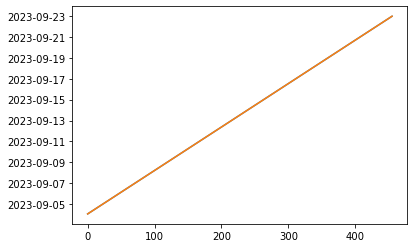

In [55]:
dtime = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=i) for i in vars_dic['TIME']])
time_out = vars_dic['TIME']
plt.plot(dtime)
plt.plot(dtime)
print(dtime[0],dtime[-1])

In [57]:
''' Write merged GFS data to netcdf file'''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'GFS.merge.sfc.'+datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
lon_dim = ncfile.createDimension('longitude', vars_dic['UFLX_AVE'].shape[2])
lat_dim = ncfile.createDimension('latitude', vars_dic['UFLX_AVE'].shape[1])
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for GFS sfc data between '+datelim[0].strftime('%Y%m%d')+\
    ' and '+datelim[-1].strftime('%Y%m%d')
print(ncfile.title)
ncfile.subtitle="Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution."
print(ncfile.subtitle)
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 456)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 615)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 329)
Merged files for GFS sfc data between 20230904 and 20230922
Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230904 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(456), longitude(615), latitude(329)
    variables(dimensions): 
    groups: 


In [58]:
### Creating variables
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
vars_names = ['LON','LAT','UFLX_AVE','VFLX_AVE']
### 2: (Y, X) 3: (time, Y, X)
dim_cat = [2,2,3,3]
for i, var_name in enumerate(vars_names):
    print(var_name)
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 2:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + "', np.float64, ('" + 'latitude' + "','"+ 'longitude' +"'))"
    elif dim_cat[i] == 3:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    exec(str_exec)
    print(i,str_exec)
    ### add attributes
attr_keys = vars_dic_attr.keys()
str_no = ['TIME']
for attr_key in attr_keys:
    i_ = attr_key.find('-')
    if attr_key[:i_] not in str_no:
        str_exec = attr_key.replace('-','.') + " = '"+ str(vars_dic_attr[attr_key]) + "'"
        exec(str_exec)

LON
0 LON= ncfile.createVariable('LON', np.float64, ('latitude','longitude'))
LAT
1 LAT= ncfile.createVariable('LAT', np.float64, ('latitude','longitude'))
UFLX_AVE
2 UFLX_AVE= ncfile.createVariable('UFLX_AVE', np.float64, ('time','latitude','longitude'))
VFLX_AVE
3 VFLX_AVE= ncfile.createVariable('VFLX_AVE', np.float64, ('time','latitude','longitude'))


In [59]:
### writing data
# Note: the ":" is necessary in these "write" statements
time[:] = time_out
for i, var_name in enumerate(vars_names):
    if dim_cat[i] == 2:
        str_exec = var_name + "[:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 3:
        str_exec = var_name + "[:,:,:]= vars_dic['" + var_name + "']"
    exec(str_exec)
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230904 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(456), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
Dataset is closed!
